In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

## Collect points from video

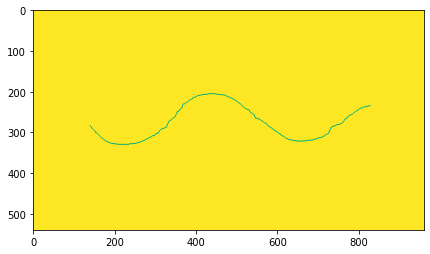

In [9]:
all_x, all_y = [],[]
collect_x, collect_y = [],[]
cap = cv2.VideoCapture('top.mp4')
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        # removing background
        alpha = 3.0
        beta = -160
        frame = alpha * frame + beta
        frame = np.clip(frame, 0, 255).astype(np.uint8)
        # Convert to grayscale and binary threshold
        img_grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret,img_grey = cv2.threshold(img_grey,50,255,cv2.THRESH_BINARY)
        # Erode more background to get thicker snake
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
        erosion = cv2.erode(img_grey,np.ones((5,5),dtype='uint8'),iterations=10)
        # Manually invert binarization
        erosion[erosion==0] = 1
        erosion[erosion==255] = 0
        # skeletonoze foreground/snake
        erosion = np.array(skeletonize(erosion), dtype='uint8')
        # manually binarize
        erosion[erosion==0] = 255
        erosion[erosion==1] = 0
        # get points of snake body
        indices = np.where(erosion==0)
        all_y.extend(indices[0].tolist())
        all_x.extend(indices[1].tolist())
        collect_y.append(indices[0].tolist())
        collect_x.append(indices[1].tolist())
        # plot snake
        cv2.imshow('Frame', erosion)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else: 
        break
cap.release()
cv2.destroyAllWindows()

In [5]:
def restructure_data(collect_x, collect_y):
    new_x, new_y = [], []
    sc = StandardScaler()
    for i in range(len(collect_x)):
        x1 = np.array(collect_x[i])-min(collect_x[i])
        y1 = sc.fit_transform(np.array(collect_y[i]).reshape((-1,1))).reshape((-1,))
        ind = np.argsort(x1)
        x1, y1 = x1[ind], y1[ind]
        new_x.append(np.deg2rad(x1))
        new_y.append(y1)
    return new_x, new_y

In [6]:
new_x, new_y = restructure_data(collect_x, collect_y)

In [13]:
np.savez_compressed('points', ax=all_x, ay=all_y, cx=collect_x, cy=collect_y, nx=new_x, ny=new_y)